In [1]:
# Libraries

import argparse
import os
import platform
import itertools
import ray
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tuner

ray.init(include_dashboard = False)

from ray.tune import choice
from ray.tune import uniform
from ray.tune import loguniform
from ray.tune import randint
from ray.tune import grid_search

2023-06-20 14:55:38,886	INFO worker.py:1538 -- Started a local Ray instance.


In [4]:
# Code

from source.python.raytune import raytune_data
from source.python.raytune import raytune_model
from source.python.raytune import raytune_plot
from source.python.raytune import raytune_utils
from source.python.io      import loader
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [5]:
# Define output and inputs

MODEL_ARCH       = 'zrimec'
MODEL_MODE       = 'regression'
MODEL_PARAMS     = None
MODEL_EPOCHS     = 5

TARGET_GROUP     = 'tissue'
TARGET_TYPE      = 'mean'
TARGET_EXPLODE   = False
TARGET_FILTER    = None

TUNER_CONCURRENT = 1
TUNER_TRIALS     = 5
TUNER_GRACE      = 5
TUNER_NOTEBOOK   = True
TUNER_SEARCH     = 'hyperopt'

FILTER_ID        = 2
GENERATOR        = 'group'
FEATURES         = True
SEQUENCE_END     = None
SEQUENCE_START   = None

In [6]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')
	print()

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')
	print()

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	parser.add_argument('--target_group',     type = str,         default = 'global',     choices = ['tissue', 'group', 'age', 'global', 'perturbation'])
	parser.add_argument('--target_type',      type = str,         default = 'mean',       choices = ['mean', 'max'])
	parser.add_argument('--target_explode',   type = str_of_bool, default = False)
	parser.add_argument('--target_filter',    type = str_or_none, default = None)
	parser.add_argument('--model_arch',       type = str,         default = 'zrimec',     choices = ['washburn', 'zrimec'])
	parser.add_argument('--model_mode',       type = str,         default = 'regression', choices = ['regression', 'classification'])
	parser.add_argument('--model_epochs',     type = int,         default = 500)
	parser.add_argument('--tuner_search',     type = str,         default = 'hyperopt',   choices = ['hyperopt', 'grid', 'gridsearch', 'random', 'randomsearch'])
	parser.add_argument('--tuner_concurrent', type = int,         default = 5)
	parser.add_argument('--tuner_trials',     type = int,         default = 250)
	parser.add_argument('--tuner_grace',      type = int,         default = 10)
	parser.add_argument('--filter_id',        type = int,         default = 0)
	parser.add_argument('--generator',        type = str,         default = 'group',      choices = ['stratified', 'group', 'random'])
	parser.add_argument('--features',         type = str_of_bool, default = True)
	parser.add_argument('--sequence_start',   type = int_or_none, default = None)
	parser.add_argument('--sequence_end',     type = int_or_none, default = None)

	args = vars(parser.parse_args())

	TARGET_GROUP     = args['target_group']
	TARGET_TYPE      = args['target_type']
	TARGET_EXPLODE   = args['target_explode']
	TARGET_FILTER    = args['target_filter']
	MODEL_ARCH       = args['model_arch']
	MODEL_MODE       = args['model_mode']
	MODEL_EPOCHS     = args['model_epochs']
	TUNER_CONCURRENT = args['tuner_concurrent']
	TUNER_TRIALS     = args['tuner_trials']
	TUNER_GRACE      = args['tuner_grace']
	TUNER_SEARCH     = args['tuner_search']
	FILTER_ID        = args['filter_id']
	GENERATOR        = args['generator']
	FEATURES         = args['features']
	SEQUENCE_START   = args['sequence_start']
	SEQUENCE_END     = args['sequence_end']

	TUNER_NOTEBOOK   = False

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

Running as .ipynb



In [7]:
# Setup some directory paths.

SUB_FILTER = 'filter' + str(FILTER_ID)
SUB_OUTPUT = '{}-f{}-{}'.format(MODEL_ARCH, FILTER_ID, MODEL_MODE[0])

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp06-tuner', 'data', SUB_OUTPUT)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_TUNER = os.path.join(RES,      'tuner')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature', SUB_FILTER)
RES_NBP05 = os.path.join(OUT,      'nbp05-target',  SUB_FILTER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_TUNER}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\data\zrimec-f2-r
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\data\zrimec-f2-r\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter2
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter2



In [8]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 7.584 GB



# 2. Tuner

In [9]:
# Define basic data parameters

CONFIG = {
	'core/device'             : DEVICE,
	'core/outdir'             : OUT_DATA,
	'core/random'             : None,
	'core/rootdir'            : ROOT,
	'core/subfolder'          : SUB_FILTER,
	'core/plots'              : 5,
	'dataset/expanddim'       : None,
	'dataset/filepath'        : os.path.join(OUT_DATA, 'dataset.pkl'),
	'dataset/sequence/start'  : SEQUENCE_START,
	'dataset/sequence/end'    : SEQUENCE_END,
	'dataset/split/generator' : GENERATOR,
	'dataset/split/test'      : 0.2,
	'dataset/split/valid'     : 0.2,
	'model/epochs'            : MODEL_EPOCHS,
	'model/features'          : FEATURES,
	'model/input/channels'    : 1,
	'model/input/features'    : None,
	'model/input/height'      : 4,
	'model/input/width'       : 2150,
	'model/mode'              : MODEL_MODE,
	'model/name'              : MODEL_ARCH,
	'model/output/explode'    : TARGET_EXPLODE,
	'model/output/filter'     : TARGET_FILTER,
	'model/output/heads'      : None,
	'model/output/size'       : None,
	'model/output/target'     : TARGET_GROUP,
	'model/output/type'       : TARGET_TYPE,
	'params/filepath'         : RES_TUNER,
	'params/tuner'            : None,
	'tuner/checkpoint'        : False,
	'tuner/max_concurrent'    : TUNER_CONCURRENT,
	'tuner/max_epochs'        : MODEL_EPOCHS,
	'tuner/min_epochs'        : TUNER_GRACE,
	'tuner/reporter/freq'     : 30,
	'tuner/reporter/notebook' : TUNER_NOTEBOOK,
	'tuner/search'            : TUNER_SEARCH,
	'tuner/stopper'           : True,
	'tuner/stopper/days'      : 3,
	'tuner/stopper/hours'     : 22,
	'tuner/stopper/minutes'   : 0,
	'tuner/trials'            : TUNER_TRIALS
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

if CONFIG['model/name'] == 'zrimec'   : CONFIG['dataset/expanddim'] = None
if CONFIG['model/name'] == 'washburn' : CONFIG['dataset/expanddim'] = 0

In [10]:
# Prints

print('Model Name      : {}'.format(CONFIG['model/name']))
print('Model Mode      : {}'.format(CONFIG['model/mode']))
print('Use Features    : {}'.format(CONFIG['model/features']))
print('Split Generator : {}'.format(CONFIG['dataset/split/generator']))
print('Random Seed     : {}'.format(CONFIG['core/random']))
print()

Model Name      : zrimec
Model Mode      : regression
Use Features    : True
Split Generator : group
Random Seed     : 961721544



# 3. Search Space

In [11]:
# Define search space

MIN_BINS = 2
MAX_BINS = 9

MIN_LAMBDA = -0.60
MAX_LAMBDA =  0.20

param_space = dict()

param_space['boxcox/lambda'] = uniform(MIN_LAMBDA, MAX_LAMBDA)
param_space['class/bins']    = randint(MIN_BINS, MAX_BINS)

if CONFIG['tuner/search'] == 'gridsearch' :
	param_space['class/bins'] = grid_search(list(range(MIN_BINS, MAX_BINS)))

# 4. Tuning

In [12]:
# Create initial params

FORCE_BINS   = 2
FORCE_LAMBDA = [
	-0.2856529777226888,
	-0.1455266110158969,
	 0.0000000000000000
]

if CONFIG['model/mode'] == 'classification' :
	FORCE_BINS = list(range(MIN_BINS, MAX_BINS))
else :
	FORCE_BINS = [FORCE_BINS]

PARAMS = list()

for item in itertools.product(FORCE_LAMBDA, FORCE_BINS) :
	PARAMS.append({
		'boxcox/lambda' : item[0],
		'class/bins'    : item[1]
	})

In [13]:
# Create tuner config

trainable = raytune_utils.create_trainable(
	method    = raytune_data.main,
	config    = CONFIG,
	cpu_count = SYSTEM['platform/cpu/count'],
	gpu_count = SYSTEM['platform/gpu/count']
)

tune_config = raytune_utils.create_tune_config(
	config    = CONFIG,
	algorithm = CONFIG['tuner/search'],
	params    = PARAMS
)

run_config = raytune_utils.create_run_config(
	config    = CONFIG,
	local_dir = OUT_DATA,
	verbosity = raytune_utils.VERBOSE_STATUS,
	task      = 'data'
)

In [14]:
# Create tune and fit

tuner = raytune_utils.create_tuner(
	trainable   = trainable,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-06-20 16:07:18,220	INFO tune.py:762 -- Total run time: 4292.41 seconds (4291.87 seconds for the tuning loop).


# 5. Reports

In [15]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
	print()
else :
	print('No errors.')
	print()

No errors.



In [16]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	print('{:<40s}'.format(column), end = ' ')

	if index % 3 == 0 :
		print()

print()
print()

valid_loss                               valid_r2                                 valid_mae                                
valid_mape                               valid_wmape                              train_loss                               
train_r2                                 train_mae                                train_mape                               
train_wmape                              lr                                       time_this_iter_s                         
done                                     timesteps_total                          episodes_total                           
training_iteration                       trial_id                                 experiment_id                            
date                                     timestamp                                time_total_s                             
pid                                      hostname                                 node_ip                                  
time_sin

In [17]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min()  / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max()  / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum()  / 60.0))
print('    Mean training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].mean() / 60.0))
print()

if CONFIG['model/mode'] == 'regression' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1'
	]]

trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :     13.9 minutes
 Longest training time :     14.8 minutes
   Total training time :     71.0 minutes
    Mean training time :     14.2 minutes



,trial_id,logdir,time_total_s,training_iteration,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
3,dc044c96,C:\Developer\Workspace\PyCharm\Projects\upolan...,850.817,5,0.206,0.055,0.373,8.816,0.324,0.472,-1.241,0.612,4.405,0.530
0,aae5a6a1,C:\Developer\Workspace\PyCharm\Projects\upolan...,850.964,5,0.440,0.101,0.544,10.772,0.358,0.609,-0.241,0.667,7.388,0.437
1,b50d85f3,C:\Developer\Workspace\PyCharm\Projects\upolan...,837.546,5,0.756,0.131,0.707,12.603,0.384,1.596,-0.813,1.063,5.898,0.573
2,2f186e0c,C:\Developer\Workspace\PyCharm\Projects\upolan...,831.267,5,1.491,0.147,0.974,15.174,0.422,2.274,-0.252,1.201,9.204,0.515
4,1386d619,C:\Developer\Workspace\PyCharm\Projects\upolan...,888.423,5,2.769,0.170,1.290,17.775,0.456,4.790,-0.368,1.674,8.866,0.582


In [18]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, 'report.csv')
)

## 5.1 Visualization

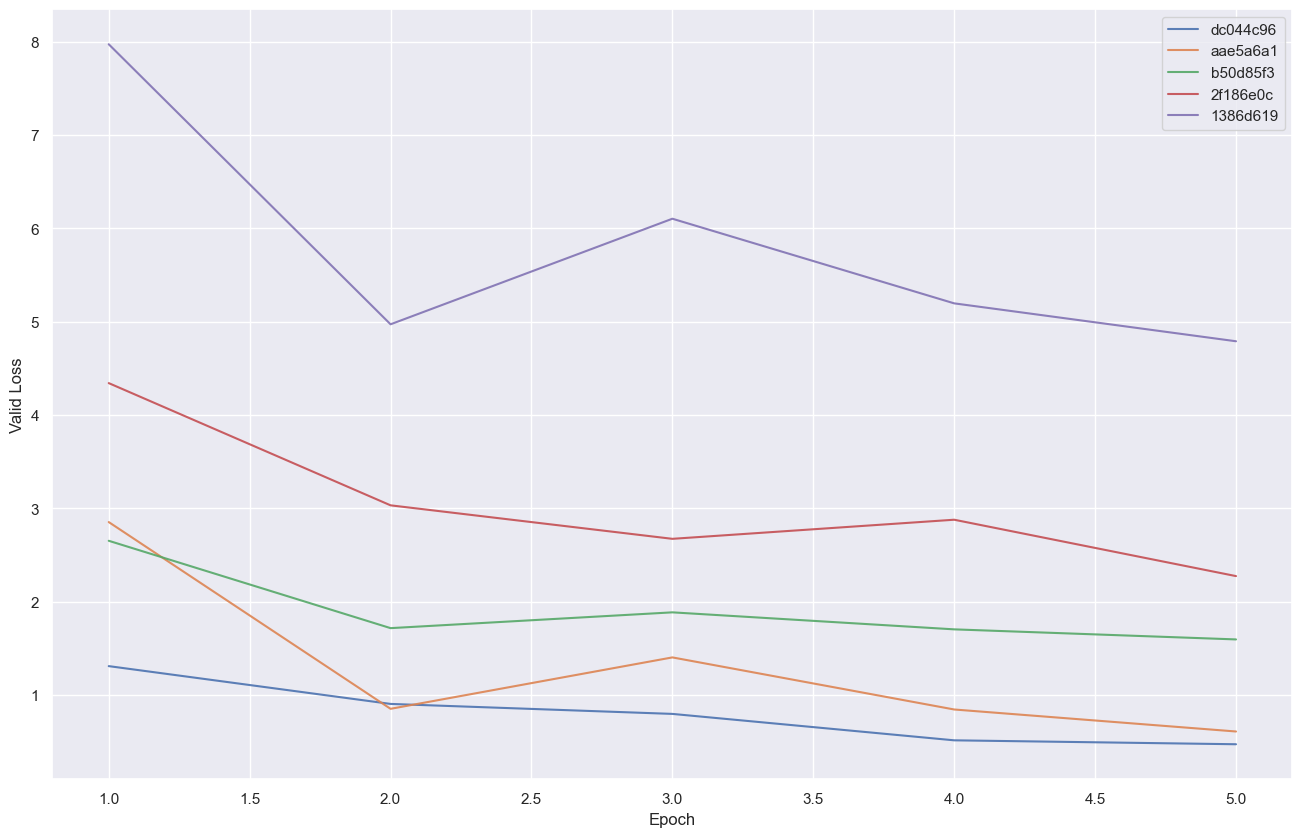

In [19]:
# Plot trials valid loss

raytune_plot.trials_lineplot_loss(
	dataframe  = trials,
	max_trials = CONFIG['core/plots'],
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials')
)

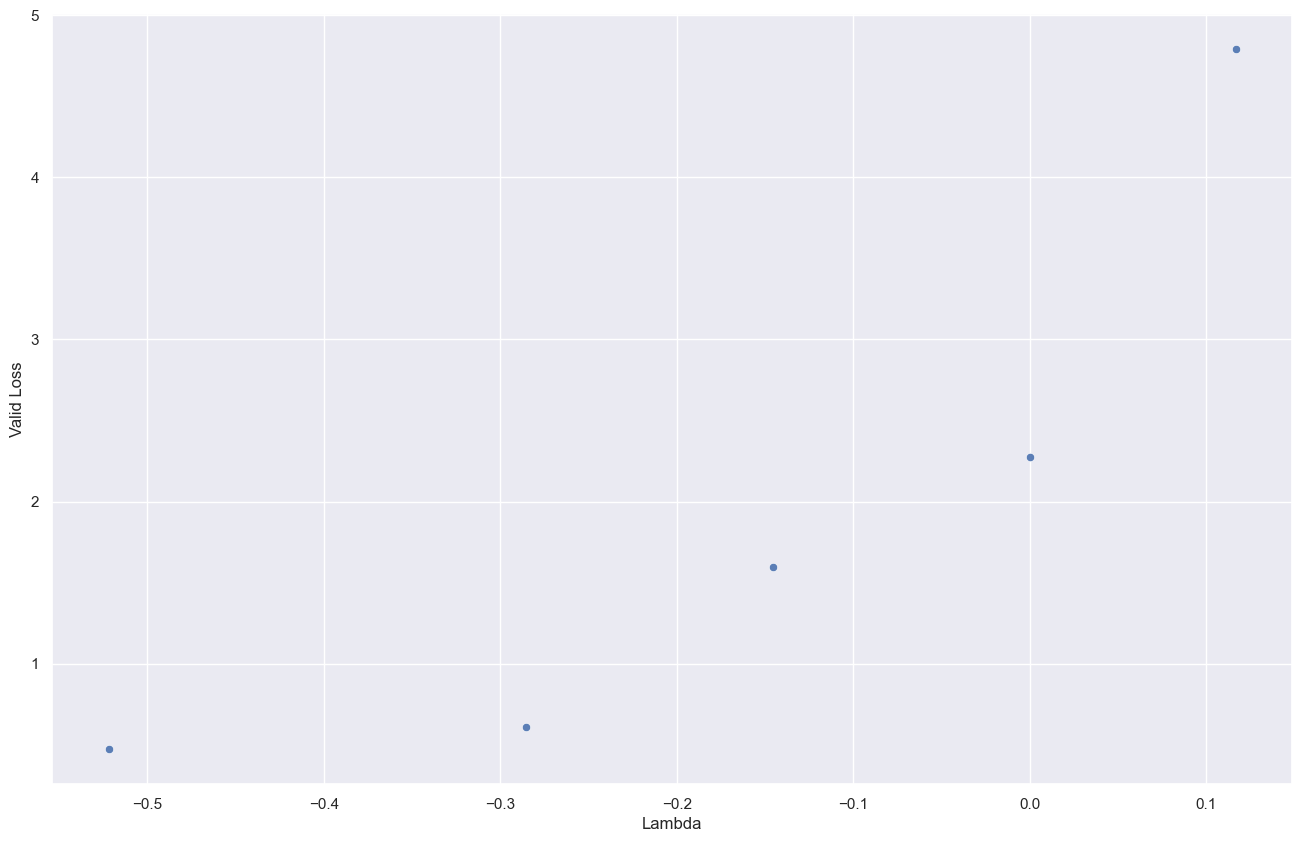

In [20]:
# Plot trials boxcox lambda vs. valid loss; clip loss values to range to bypass extreme values that would descale the plot

raytune_plot.trials_scatterplot_lambda_loss(
	dataframe = dataframe,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials'),
	clip       = None
)

### 5.1.1 Regression

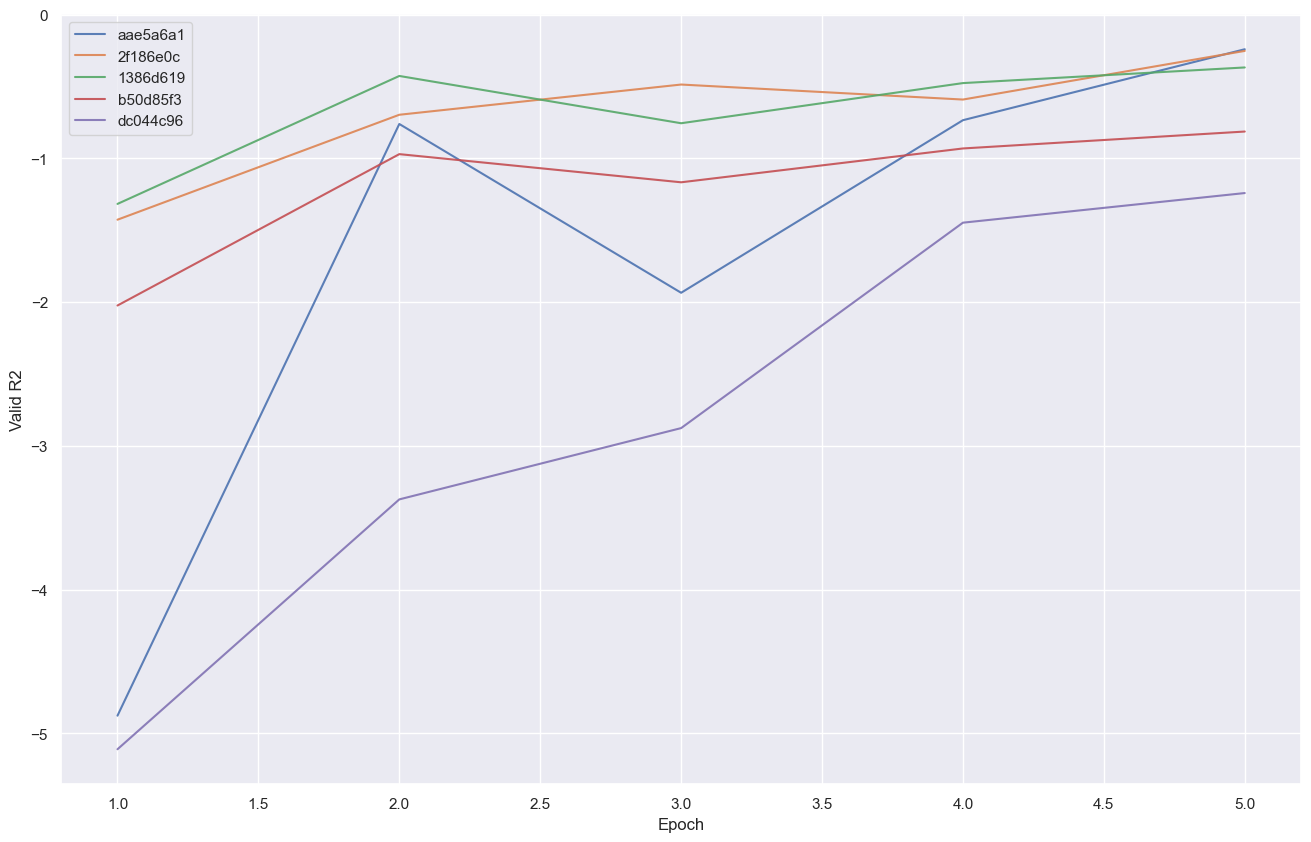

In [21]:
# Plot trials valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_lineplot_r2(
		dataframe  = trials,
		max_trials = CONFIG['core/plots'],
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials')
	)

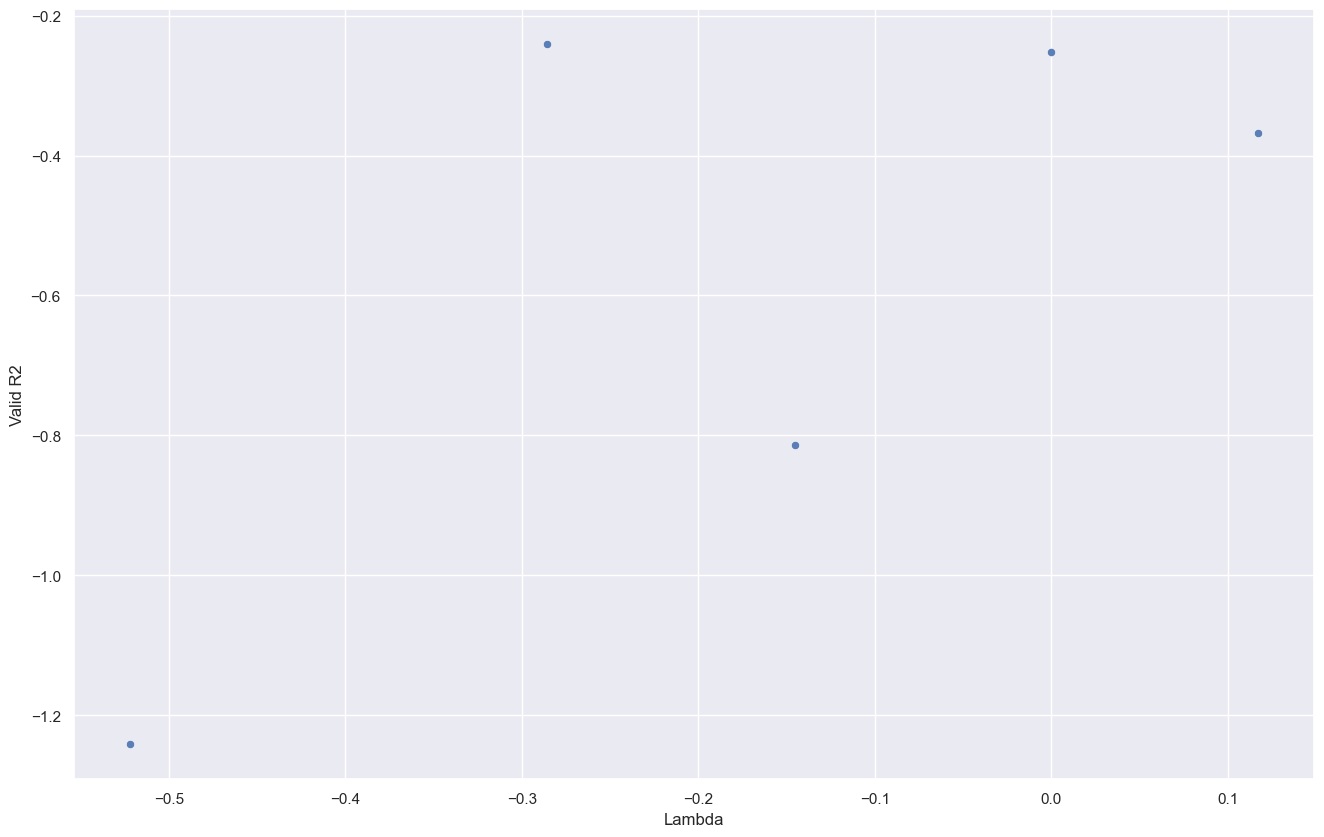

In [22]:
# Plot trials boxcox lambda vs. valid r2; clip r2 values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_r2(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials'),
		clip       = (-2.0, None)
	)

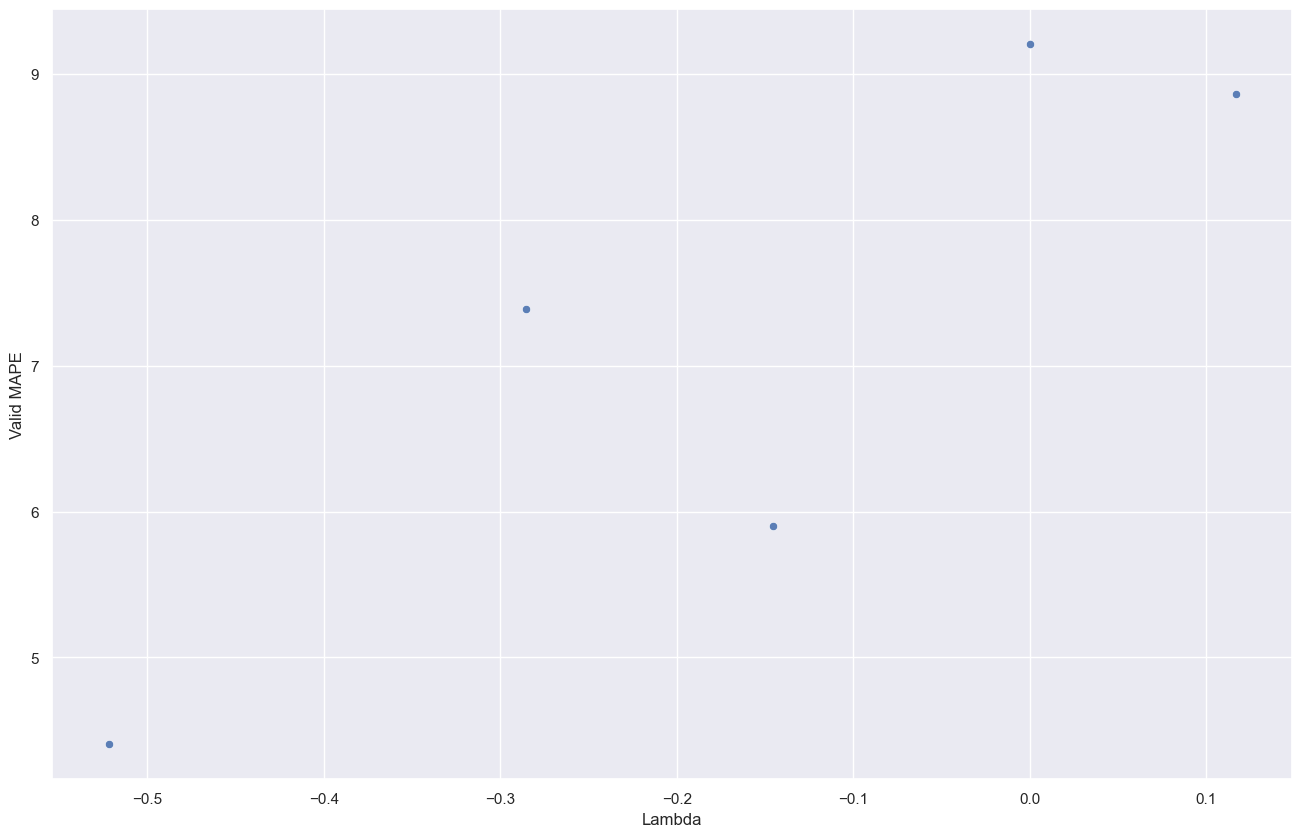

In [23]:
# Plot trials boxcox lambda vs. valid mape; clip mape values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_mape(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials'),
		clip       = None
	)

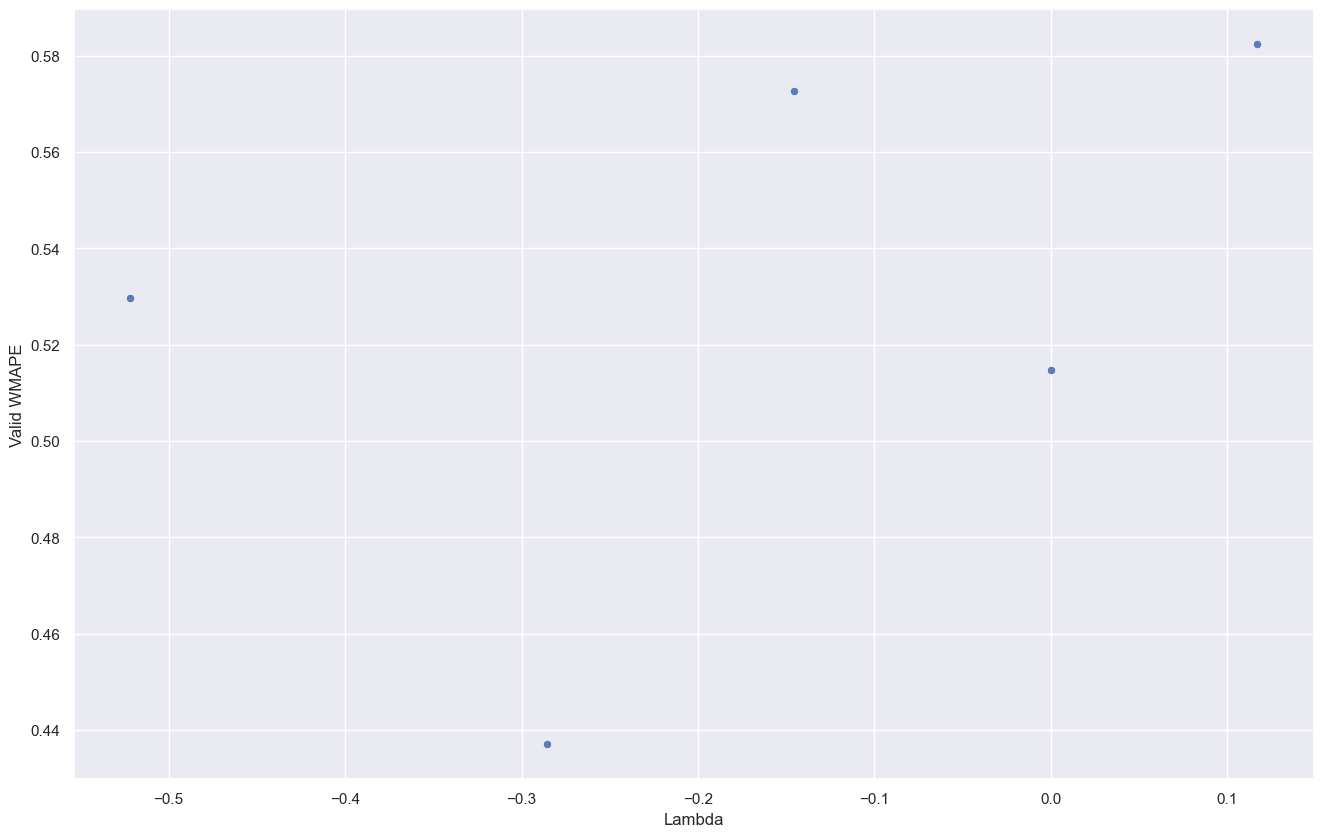

In [24]:
# Plot trials boxcox lambda vs. valid wmape; clip mape values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_wmape(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials'),
		clip       = None
	)

### 5.1.2 Classification

In [25]:
# Plot trials valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_lineplot_accuracy(
		dataframe  = trials,
		max_trials = CONFIG['core/plots'],
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials')
	)

In [26]:
# Plot trials boxcox lambda vs. valid accuracy; clip accuracy values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_accuracy(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials'),
		clip       = None
	)

In [27]:
# Plot trials boxcox lambda vs. valid auroc; clip auroc values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_auroc(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials'),
		clip       = None
	)

In [28]:
# Plot trials boxcox lambda vs. valid f1; clip f1 values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_f1(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials'),
		clip       = None
	)

In [29]:
# Plot trials boxcox lambda vs. number of classification bins for accuracy

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_accuracy(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials')
	)

In [30]:
# Plot trials boxcox lambda vs. number of classification bins for f1

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_f1(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials')
	)

In [31]:
# Plot trials boxcox lambda vs. number of classification bins for auroc

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_auroc(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials')
	)

In [32]:
# Plot trials boxcox lambda vs. number of classification bins for matthews

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_matthews(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-trials')
	)

## 5.2 Best

In [33]:
# Display best trial

best = report.get_best_result()

if CONFIG['model/mode'] == 'regression'     : metrics = ['loss', 'r2', 'mae', 'mape', 'wmape']
if CONFIG['model/mode'] == 'classification' : metrics = ['loss', 'accuracy', 'auroc', 'f1', 'matthews']

for mode, metric in itertools.product(['train', 'valid'], metrics) :
	k0 = 'metrics/{}/{}'.format(mode, metric)
	k1 = '{}_{}'.format(mode, metric)

	best.config[k0] = float(best.metrics[k1])

print('Best config :')
print()
print('{')

for index, (key, val) in enumerate(sorted(best.config.items()), start = 1) :
	if isinstance(key, str)   : key = f'"{key}"'
	if isinstance(val, str)   : val = f'"{val}"'

	if isinstance(val, float) : print('\t{:30s} : {:.16f}'.format(key, val), end = '')
	else                      : print('\t{:30s} : {}'.format(key, val), end = '')

	if index < len(best.config) : print(',')
	else                        : print('')

print('}')
print()

Best config :

{
	"boxcox/lambda"                : -0.5219108224055777,
	"class/bins"                   : 4,
	"metrics/train/loss"           : 0.2061485470518921,
	"metrics/train/mae"            : 0.3727140038494197,
	"metrics/train/mape"           : 8.8160684012138439,
	"metrics/train/r2"             : 0.0545459948480129,
	"metrics/train/wmape"          : 0.3240939080715179,
	"metrics/valid/loss"           : 0.4723068344193536,
	"metrics/valid/mae"            : 0.6122196527015004,
	"metrics/valid/mape"           : 4.4047534830012198,
	"metrics/valid/r2"             : -1.2413976192474365,
	"metrics/valid/wmape"          : 0.5297946929931641
}



In [34]:
# Display per iteration

progress = loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

if CONFIG['model/mode'] == 'regression' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1', 'train_matthews',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1', 'valid_matthews'
	]]

progress

,trial_id,time_total_s,training_iteration,lr,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
0,dc044c96,463.413,1,0.000,0.392,-0.829,0.486,9.347,0.423,1.309,-5.111,1.041,5.707,0.902
1,dc044c96,562.843,2,0.000,0.245,-0.127,0.407,8.658,0.354,0.904,-3.373,0.860,3.020,0.744
2,dc044c96,662.214,3,0.000,0.227,-0.046,0.390,8.902,0.339,0.797,-2.877,0.807,2.932,0.698
3,dc044c96,756.444,4,0.000,0.213,0.021,0.379,8.634,0.329,0.514,-1.447,0.639,4.139,0.553
4,dc044c96,850.817,5,0.000,0.206,0.055,0.373,8.816,0.324,0.472,-1.241,0.612,4.405,0.530


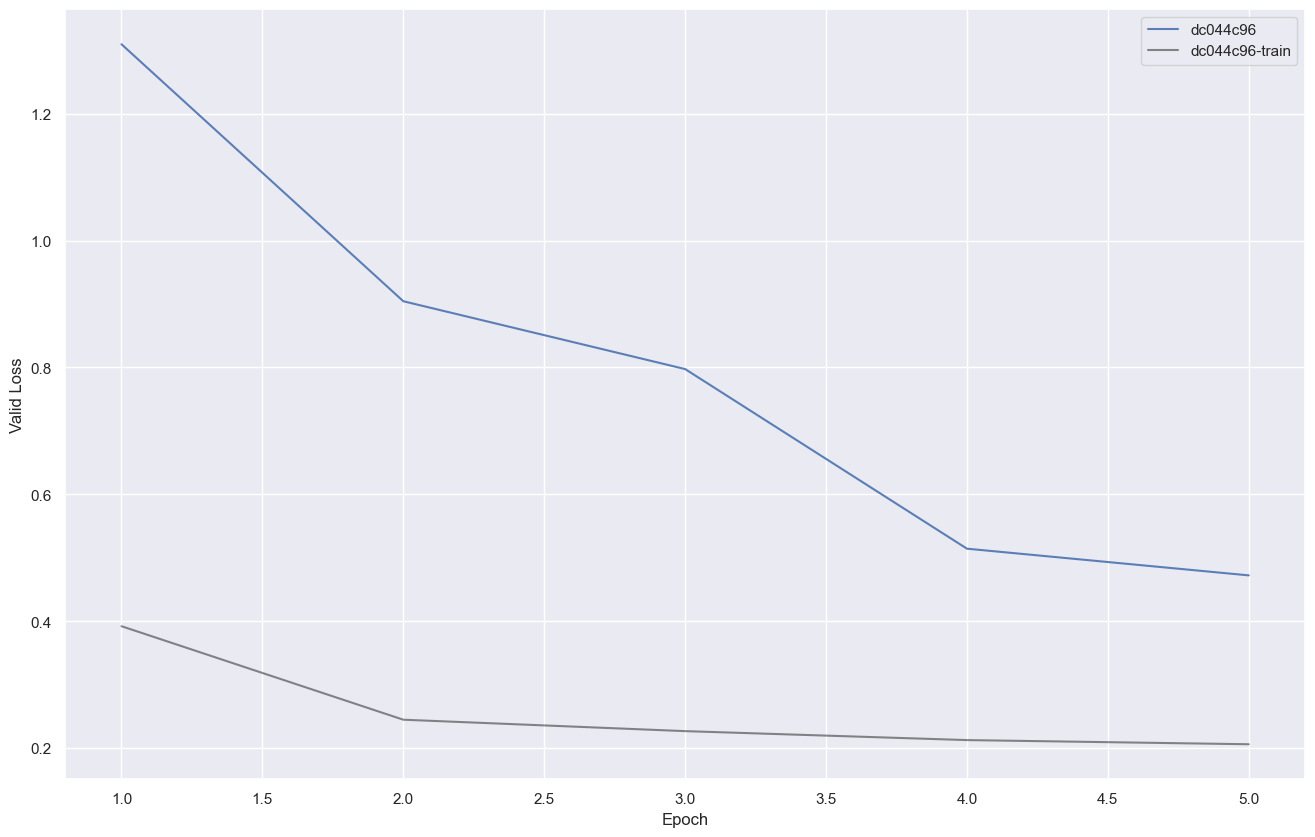

In [35]:
# Plot best trial valid loss

raytune_plot.trial_lineplot_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-best')
)

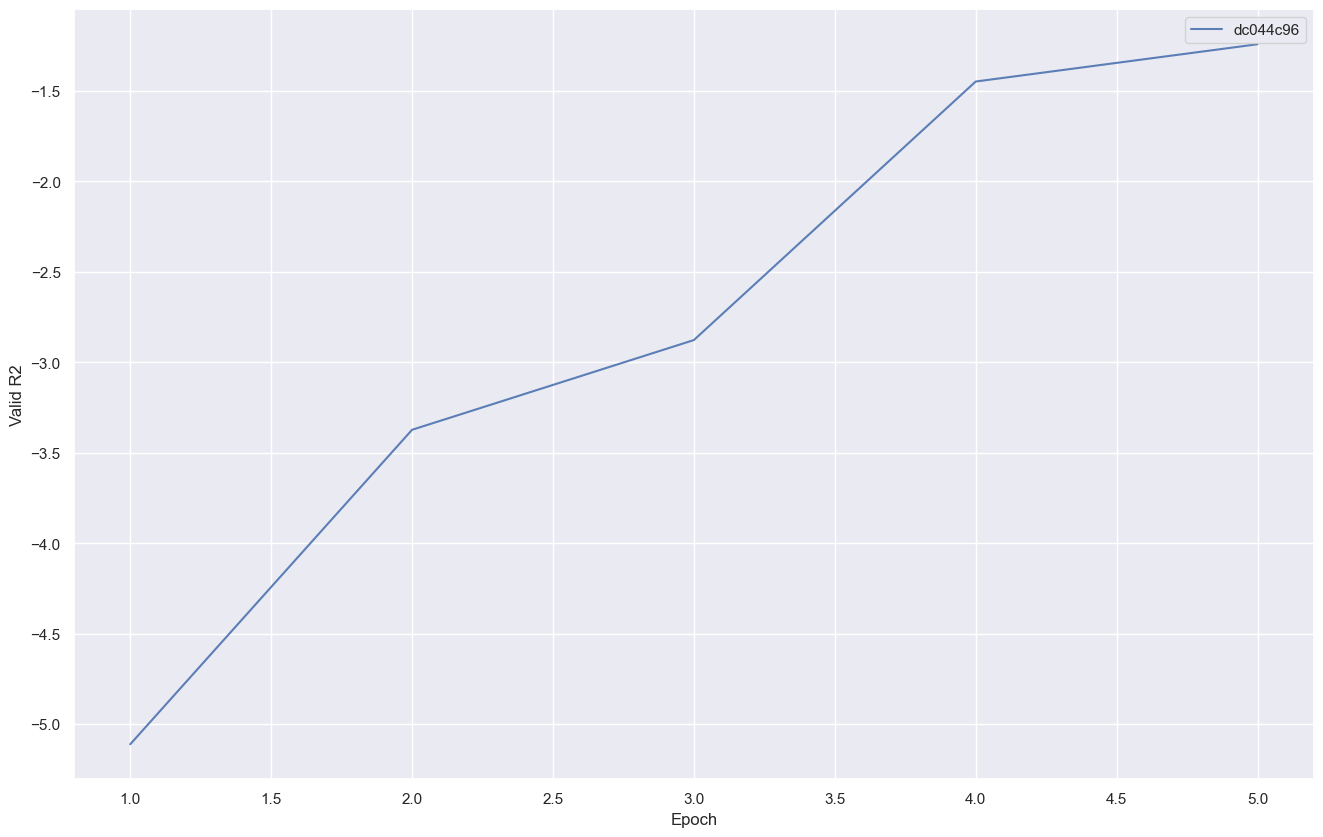

In [36]:
# Plot best trial valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trial_lineplot_r2(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-best')
	)

In [37]:
# Plot best trial valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trial_lineplot_accuracy(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-best')
	)

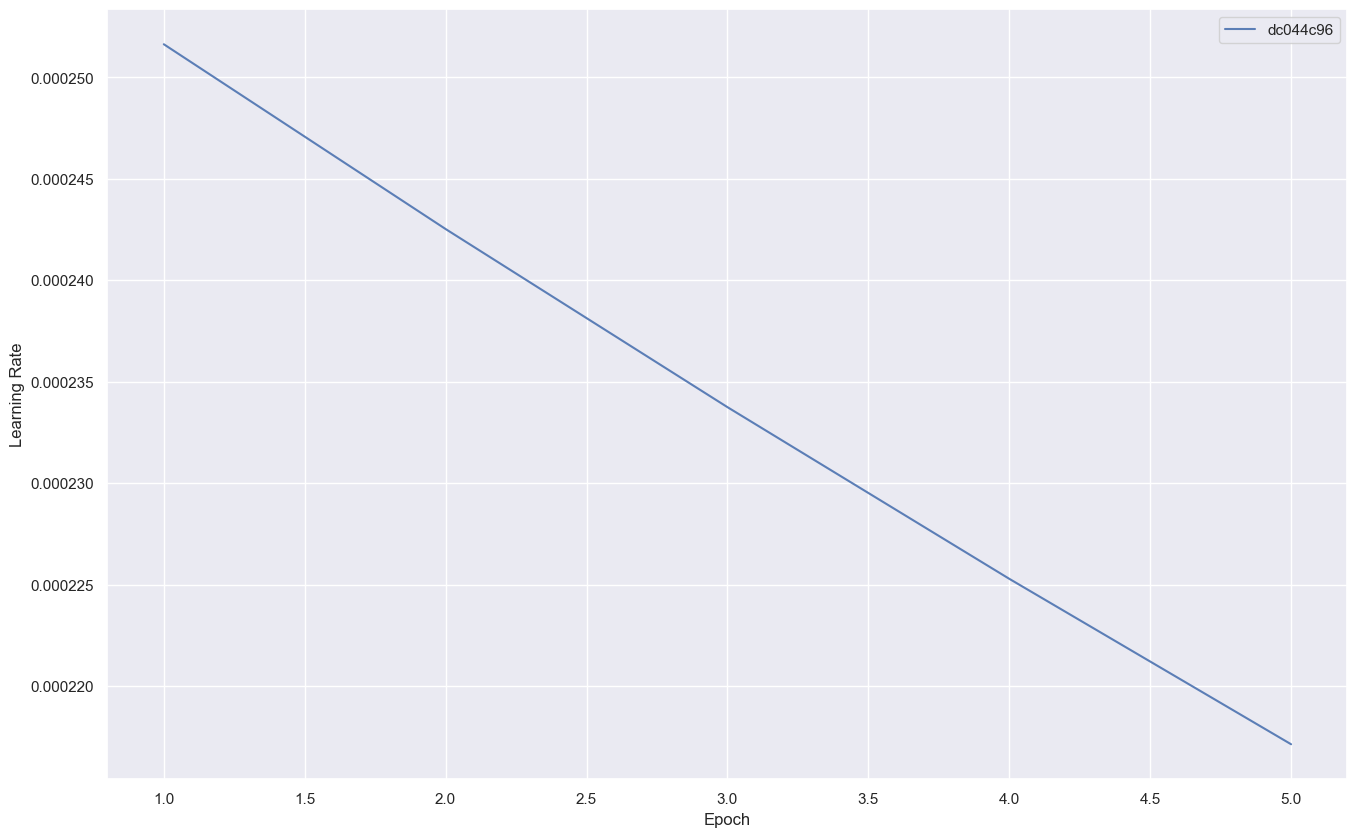

In [38]:
# Plot trials learning rate

raytune_plot.trial_lineplot_lr(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/name'] + '-best')
)